## How to create a neural network in PyTorch

Torch is a numerical computation library like Numpy but instead of arrays, it uses tensors. 

Tensors behave the same way as arrays but PyTorch has extra functionality under the hood which builds a computation graph as you perform calculations on the tensors and calculate gradients with one line of code.

In [1]:
import torch

#there are many ways of initializing tensors
a = torch.Tensor([1, 2])
b = torch.arange(10).view(5, 2)
c = torch.zeros(10, 2)

### Exercise 1 
The code below shows linear regression implemented and optimized in pytorch using randomly generated data. Try to load the Iris dataset (google it) and perform classficiation by altering the code.

In [2]:
#linear regression optimized using gradient descent in pytorch from scratch
lr = 0.001
epochs = 5
x = torch.randn(100, 4) #the input
y = torch.randn(100, 1) #the labels
weights = torch.randn((4, 1), requires_grad=True) #initialized weights, we will need to calculate gradients for this tensor
optimizer = torch.optim.Adam([weights], lr=lr) #optimizer object to optimize the weights tensor

for i in range(epochs):
    pred = torch.matmul(x, weights)
    cost = torch.sum(torch.pow(pred-y, 2))
    
    optimizer.zero_grad() #forget currently stored gradients
    cost.backward() #calculate gradients of tensors (which have requires_grad=True) with respect to the cost tensor
    optimizer.step() #update the weights using the calculated gradients
    
    print('Epoch cost:', cost.item()) #print cost for this epoch

Epoch cost: 822.7669067382812
Epoch cost: 821.690673828125
Epoch cost: 820.6154174804688
Epoch cost: 819.5408325195312
Epoch cost: 818.46728515625


### Exercise 2
Follow along and try to understand how the code below which trains a neural network classifier on the MNIST dataset works. Alter the code below, loading the FashionMNIST dataset instead and with a different neural network architecture.

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms, datasets
import torch.nn.functional as F

#-------------- loading in data --------------
batch_size=256

#load the 60000 MNIST training example
train_data = datasets.MNIST(root='MNIST-data',
                                transform=transforms.ToTensor(),
                                train=True,
                                download=True
                                )
#split into 50000 training examples and 10000 validation examples
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])

test_data = datasets.MNIST(root='MNIST-data',
                            transform=transforms.ToTensor(),
                            train=False
                            )

#store size of each dataset split
train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)

# dataloader is a generator that returns minibatches from a dataset
train_samples = torch.utils.data.DataLoader(dataset=train_data,
                                              batch_size=batch_size,
                                              shuffle=True)

val_samples = torch.utils.data.DataLoader(dataset=train_data,
                                              batch_size=batch_size,
                                              shuffle=True)

test_samples = torch.utils.data.DataLoader(dataset=test_data,
                                            batch_size=batch_size,
                                            shuffle=False)

#-------------- define the class for our neural network --------------
class MNIST_NN(torch.nn.Module):
    def __init__(self):
        #initialize weights matrices
        super().__init__()
        #our input is 28x28 black and white images of digits flatten to 1x784 vector
        self.dense1 = torch.nn.Linear(784, 1024) #matrix from input to first hidden layer
        self.dense2 = torch.nn.Linear(1024, 256) #matrix from first hidden layer to second hidden layer
        self.dense3 = torch.nn.Linear(256, 10) #matrix from second hidden layer to output
    
    #define operation to calculate output given input x
    def forward(self, x):
        x = F.relu((self.dense1(x.view(-1, 784))))
        x = F.relu((self.dense2(x)))
        x = F.softmax(self.dense3(x), dim=1)
        return x

#-------------- instantiate model and optimizer --------------
lr = 0.001 #learning rate
mymodel = MNIST_NN() #instantiate model from the neural network class
optimizer = torch.optim.Adam(mymodel.parameters(), lr=lr)

plt.ion()

#-------------- define training loop --------------
def train(epochs):
    plt.close()
    mymodel.train()
    
    bcosts = []
    ecosts = []
    valcosts = []
    plt.ion()
    fig = plt.figure(figsize=(5, 15))
    ax = fig.add_subplot(311)
    ax1 = fig.add_subplot(312)
    ax2 = fig.add_subplot(313)
    
    plt.show()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Cost')

    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Cost')

    ax2.axis('off')
    img_label_text = ax2.text(0, 32, '', fontsize=14)
    
    for e in range(epochs):
        ecost=0
        valcost=0
        for i, (x, y) in enumerate(train_samples):

            h = mymodel.forward(x) #calculate hypothesis
            cost = F.cross_entropy(h, y, reduction='sum') #calculate cost
            
            optimizer.zero_grad() #zero gradients
            cost.backward() # calculate derivatives of values of filters
            optimizer.step() #update parameters

            bcosts.append(cost.item()/batch_size)
            ax1.plot(bcosts, 'b', label='Train cost')
            ecost+=cost.item()
            if e==0 and i==0: ax1.legend()
            
            #show first image of batch with predicted class
            im = np.array(x[0][0])
            predicted_class = str(h.max(1)[1][0].item())
            ax2.imshow(im)
            img_label_text.set_text('Predicted class: '+ predicted_class)
            
            fig.canvas.draw()
            
        for i, (x, y) in enumerate(val_samples):

            h = mymodel.forward(x) #calculate hypothesis
            cost = F.cross_entropy(h, y, reduction='sum') #calculate cost
            valcost+=cost.item()
            
            #show first image of batch with predicted class
            im = np.array(x[0][0])
            predicted_class = str(h.max(1)[1][0].item())
            ax2.imshow(im)
            img_label_text.set_text('Predicted class: '+ predicted_class)
            fig.canvas.draw()
            
        ecost/=train_size
        valcost/=val_size
        ecosts.append(ecost)
        valcosts.append(valcost)
        ax.plot(ecosts, 'b', label='Train cost')
        ax.plot(valcosts, 'r', label='Validation cost')
        if e==0: ax.legend()
        fig.canvas.draw()

        print('Epoch', e, '\tCost', ecost)

#-------------- calculate accuracy of model on test set --------------
def test():
    print('Started evaluation...')
    mymodel.eval() #put model into evaluation mode
    
    #calculate the accuracy of our model over the whole test set in batches
    correct = 0
    for x, y in test_samples:
        h = mymodel.forward(x)
        pred = h.max(1)[1]
        correct += pred.eq(y).sum().item()
    return round(correct/test_size, 4)

0it [00:00, ?it/s]

9920512it [00:04, 2116775.33it/s]                             


Extracting MNIST-data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 119602.62it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST-data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 1728731.58it/s]                            
0it [00:00, ?it/s]

Extracting MNIST-data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 46088.78it/s]            

Extracting MNIST-data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


<IPython.core.display.Javascript object>


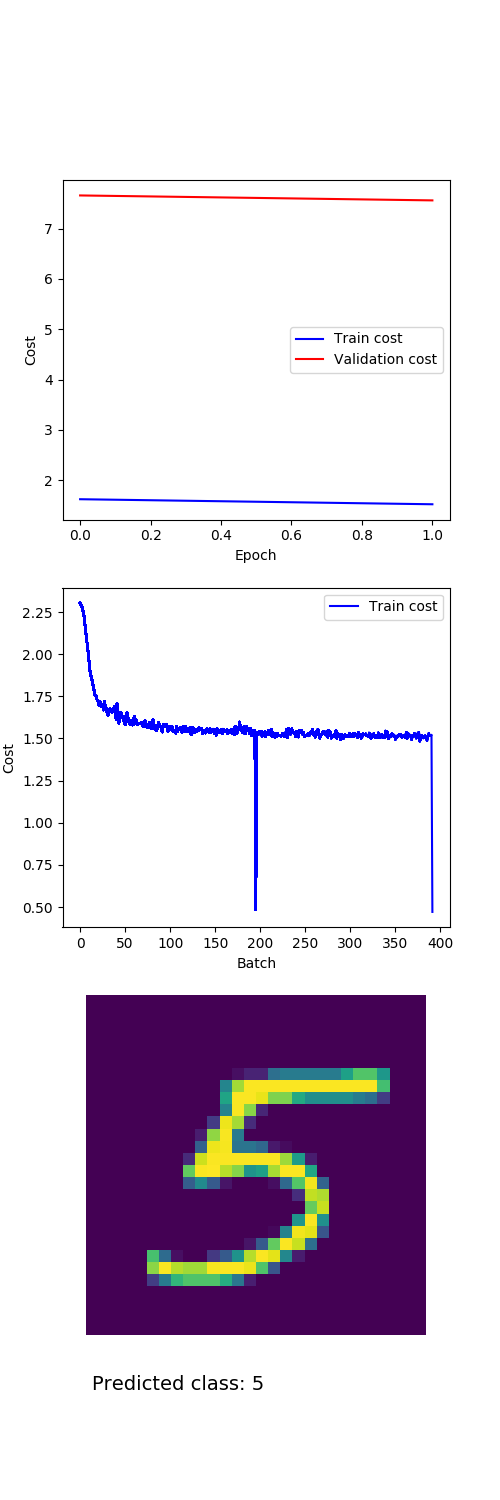

Epoch 0 	Cost 1.6215776696777344
Epoch 1 	Cost 1.5213917712402343


In [4]:
train(2)

In [ ]:
acc = test()
print('Test Accuracy', acc)